In [1]:
import pandas as pd
import numpy as np
import os

import pandas as pd
import numpy as np
from collections import Counter
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import math
from sklearn.preprocessing import MinMaxScaler
import scipy
from sklearn import metrics

import numpy as np
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr

import seaborn as sns
import matplotlib.pyplot as plt
import shap

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from scipy import stats

In [2]:
"""
Author: Caitlin Rivers
Analysis functions for package epipy.
"""
def _get_table_labels(table):
    """
    Returns classic a, b, c, d labels for contingency table calcs.
    """
    a = table[0][0]
    b = table[0][1]
    c = table[1][0]
    d = table[1][1]

    return a, b, c, d


def _ordered_table(table):
    """
    Determine type of table input. Find classic a, b, c, d labels
    for contigency table calculations.
    """
    if type(table) is list:
        a, b, c, d = _get_table_labels(table)
    elif type(table) is pd.core.frame.DataFrame:
        a, b, c, d = _get_table_labels(table.values)
    elif type(table) is np.ndarray:
        a, b, c, d = _get_table_labels(table)
    else:
        raise TypeError('table format not recognized')

    return a, b, c, d


def _conf_interval(ratio, std_error):
    """
    Calculate 95% confidence interval for odds ratio and relative risk.
    """

    _lci = np.log(ratio) - 1.96*std_error
    _uci = np.log(ratio) + 1.96*std_error

    lci = round(np.exp(_lci), 2)
    uci = round(np.exp(_uci), 2)

    return (lci, uci)

def _numeric_summary(column):
    """
    Finds count, number of missing values, min, median, mean, std, and
    max.
    See summary()
    """
    names = ['count', 'missing', 'min', 'median', 'mean', 'std', 'max']
    _count = len(column)
    _miss = _count - len(column.dropna())
    _min = column.min()
    _median = column.median()
    _mean = column.mean()
    _std = column.std()
    _max = column.max()
    summ = pd.Series([_count, _miss, _min, _median, _mean, _std, _max], index=names)

    return summ


def _categorical_summary(column, n=None):
    """
    Finds count and frequency of each unique value in the column.
    See summary().
    """
    if n is not None:
        _count = column.value_counts()[:n]
    else:
        _count = column.value_counts()
    names = ['count', 'freq']
    _freq = column.value_counts(normalize=True)[:n]
    summ = pd.DataFrame([_count, _freq], index=names).T

    return summ


def _summary_calc(column, by=None):
    """
    Calculates approporiate summary statistics based on data type.
    PARAMETERS
    ----------------------
    column = one column (series) of pandas df
    by = optional. stratifies summary statistics by each value in the
                column.
    RETURNS
    ----------------------
    if column data type is numeric, returns summary statistics
    if column data type is an object, returns count and frequency of
        top 5 most common values
    """
    if column.dtype == 'float64' or column.dtype == 'int64':
        coltype = 'numeric'
    elif column.dtype == 'object':
        coltype = 'object'


    if by is None:
        if coltype == 'numeric':
            summ = _numeric_summary(column)

        elif coltype == 'object':
            summ = _categorical_summary(column, 5)

    else:

        if coltype == 'numeric':
            column_list = []

            vals = by.dropna().unique()
            for value in vals:
                subcol = column[by == value]
                summcol = _numeric_summary(subcol)
                column_list.append(summcol)

            summ = pd.DataFrame(column_list, index=vals)

        elif coltype == 'object':
            subcol = column.groupby(by)
            summ = _categorical_summary(subcol)
            #summ = _summ.sort_values(by=subcol)

    return summ


def reproduction_number(G, index_cases=True, plot=True):
    """
    Finds each case's basic reproduction number, which is the number of secondary
    infections each case produces.
    PARAMETERS
    ----------------
    G = networkx object
    index_cases = include index nodes, i.e. those at generation 0. Default is True.
                  Excluding them is useful if you want to calculate the human to human
                  reproduction number without considering zoonotically acquired cases.
    summary = print summary statistics of the case reproduction numbers
    plot = create histogram of case reproduction number distribution.
    RETURNS
    ----------------
    pandas series of case reproduction numbers and matplotlib figure
    and axis objects if plot=True
    """

    if index_cases == True:
        R = pd.Series(G.out_degree())

    elif index_cases == False:
        degrees = {}

        for n in G.node:
            if G.node[n]['generation'] > 0:
                degrees[n] = G.out_degree(n)
        R = pd.Series(degrees)

    print('Summary of reproduction numbers')
    print(R.describe(), '\n')

    if plot == True:
        fig, ax = plt.subplots()
        R.hist(ax=ax, alpha=.5)
        ax.set_xlabel('Secondary cases')
        ax.set_ylabel('Count')
        ax.grid(False)
        return R, fig, ax

    else:
        return R


def generation_analysis(G, attribute, plot=True):
    """
    Analyzes an attribute, e.g. health status, by generation.
    PARAMETERS
    -------------
    G = networkx object
    attribute = case attribute for analysis, e.g. health status or sex
    table = print cross table of attribute by generation. Default is true.
    plot = produce histogram of attribute by generation. Default is true.
    RETURNS
    --------------
    matplotlib figure and axis objects
    """

    gen_df = pd.DataFrame(G.node).T

    print('{} by generation').format(attribute)
    table = pd.crosstab(gen_df.generation, gen_df[attribute], margins=True)
    print(table, '\n')

    if plot == True:
        fig, ax = plt.subplots()
        ax.set_aspect('auto')
        pd.crosstab(gen_df.generation, gen_df[attribute]).plot(kind='bar', ax=ax, alpha=.5, rot=0)
        ax.set_xlabel('Generation')
        ax.set_ylabel('Case count')
        ax.grid(False)
        ax.legend(loc='best');
        return fig, ax, table
    else:
        return table


def create_2x2(df, row, column, row_order, col_order):
    """
    2x2 table of disease and exposure in traditional epi order.
    Table format:
                Disease
    Exposure    YES     NO
    YES         a       b
    NO          c       d
    PARAMETERS
    -----------------------
    df = pandas dataframe of line listing
    row = name of exposure row as string
    column = name of outcome column as string
    row_order = list of length 2 of row values in yes/no order.
                Example: ['Exposed', 'Unexposed']
    col_order = list of length 2 column values in yes/no order.
                Example: ['Sick', 'Not sick']
    RETURNS
    ------------------------
    pandas dataframe of 2x2 table. Prints odds ratio and relative risk.
    """
    if type(col_order) != list or type(row_order) != list:
        raise TypeError('row_order and col_order must each be lists of length 2')

    if len(col_order) != 2 or len(row_order) != 2:
        raise AssertionError('row_order and col_order must each be lists of length 2')

    _table = pd.crosstab(df[row], df[column], margins=True).to_dict()

    trow = row_order[0]
    brow = row_order[1]
    tcol = col_order[0]
    bcol = col_order[1]

    table = pd.DataFrame(_table, index=[trow, brow, 'All'], columns=[tcol, bcol, 'All'])

    return table


def analyze_2x2(table):
    """
    Prints odds ratio, relative risk, and chi square.
    See also create_2x2(), odds_ratio(), relative_risk(), and chi2()
    PARAMETERS
    --------------------
    2x2 table as pandas dataframe, numpy array, or list in format [a, b, c, d]
    Table format:
                Disease
    Exposure    YES     NO
    YES         a       b
    NO          c       d
    """

    odds_ratio(table)
    relative_risk(table)
    attributable_risk(table)
    chi2(table)


def odds_ratio(table):
    """
    Calculates the odds ratio and 95% confidence interval. See also
    analyze_2x2()
    *Cells in the table with a value of 0 will be replaced with .1
    PARAMETERS
    ----------------------
    table = accepts pandas dataframe, numpy array, or list in [a, b, c, d] format.
    RETURNS
    ----------------------
    returns and prints odds ratio and tuple of 95% confidence interval
    """
    
    a, b, c, d = _ordered_table(table)

    ratio = (a*d)/(b*c)
    or_se = np.sqrt((1/a)+(1/b)+(1/c)+(1/d))
    or_ci = _conf_interval(ratio, or_se)
    print('Odds ratio: {} (95% CI: {})'.format(round(ratio, 2), or_ci))

    return round(ratio, 2), or_ci




def relative_risk(table, display=True):
    """
    Calculates the relative risk and 95% confidence interval. See also
    analyze_2x2().
    *Cells in the table with a value of 0 will be replaced with .1
    PARAMETERS
    ----------------------
    table = accepts pandas dataframe, numpy array, or list in [a, b, c, d] format.
    RETURNS
    ----------------------
    returns and prints relative risk and tuple of 95% confidence interval
    """
    
    a, b, c, d = _ordered_table(table)

    rr = (a/(a+b))/(c/(c+d))
    rr_se = np.sqrt(((1/a)+(1/c)) - ((1/(a+b)) + (1/(c+d))))
    rr_ci = _conf_interval(rr, rr_se)

    if display is not False:
        print('Relative risk: {} (95% CI: {}-{})\n'.format(round(rr, 2), round(rr_ci[0],2), round(rr_ci[1], 2)))

    return rr, rr_ci, rr_se


def attributable_risk(table):
    """
    Calculate the attributable risk, attributable risk percent,
    and population attributable risk.
    PARAMETERS
    ----------------
    table = 2x2 table. See 2x2_table()
    RETURNS
    ----------------
    prints and returns attributable risk (AR), attributable risk percent
    (ARP), population attributable risk (PAR) and population attributable
    risk percent (PARP).
    """
    a, b, c, d = _ordered_table(table)
    N = a + b + c + d

    ar = (a/(a+b))-(c/(c+d))
    ar_se = np.sqrt(((a+c)/N)*(1-((a+c)/N))*((1/(a+b))+(1/(c+d))))
    ar_ci = (round(ar-(1.96*ar_se), 2), round(ar+(1.96*ar_se), 2))

    rr, rci = relative_risk(table, display=False)
    arp = 100*((rr-1)/(rr))
    arp_se = (1.96*ar_se)/ar
    arp_ci = (round(arp-arp_se, 2), round(arp+arp_se, 3))

    par = ((a+c)/N) - (c/(c+d))
    parp = 100*(par/(((a+c)/N)))

    print('Attributable risk: {} (95% CI: {})'.format(round(ar, 3), ar_ci))
    print('Attributable risk percent: {}% (95% CI: {})'.format(round(arp, 2), arp_ci))
    print('Population attributable risk: {}'.format(round(par, 3)))
    print('Population attributable risk percent: {}% \n'.format(round(parp, 2)))

    return ar, arp, par, parp


def my_attributable_risk(table, print_result =  True):
    """
    Calculate the attributable risk, attributable risk percent,
    and population attributable risk.
    PARAMETERS
    ----------------
    table = 2x2 table. See 2x2_table()
    RETURNS
    ----------------
    prints and returns attributable risk (AR), attributable risk percent
    (ARP), population attributable risk (PAR) and population attributable
    risk percent (PARP).
    """
    a, b, c, d = _ordered_table(table)
    N = a + b + c + d

    ar = (a/(a+b))-(c/(c+d))
    ar_se = np.sqrt(((a+c)/N)*(1-((a+c)/N))*((1/(a+b))+(1/(c+d))))
    ar_ci = (round(ar-(1.96*ar_se), 2), round(ar+(1.96*ar_se), 2))

    rr, rci, rr_se = relative_risk(table, display=False)
    arp = 100*((rr-1)/(rr))
    arp_se = (1.96*ar_se)/ar
    arp_ci = (round(arp-arp_se, 2), round(arp+arp_se, 3))

    par = ((a+c)/N) - (c/(c+d))
    parp = 100*(par/(((a+c)/N)))

    if(print_result):
        print('Attributable risk: {} (95% CI: {})'.format(round(ar, 3), ar_ci))
        print('Attributable risk percent: {}% (95% CI: {})'.format(round(arp, 2), arp_ci))
        print('Population attributable risk: {}'.format(round(par, 3)))
        print('Population attributable risk percent: {}% \n'.format(round(parp, 2)))

    return arp, arp_ci, rr, rci, rr_se

def chi2(table):
    """
    Scipy.stats function to calculate chi square.
    PARAMETERS
    ----------------------
    table = accepts pandas dataframe or numpy array. See also
    analyze_2x2().
    RETURNS
    ----------------------
    returns chi square with yates correction, p value,
    degrees of freedom, and array of expected values.
    prints chi square and p value
    """
    chi2, p, dof, expected = chi2_contingency(table)
    #print('Chi square: {}'.format(chi2))
    #print('p value: {}'.format(p))

    return chi2, p, dof, expected


def summary(data, by=None):
    """
    Displays approporiate summary statistics for each column in a line listing.
    PARAMETERS
    ----------------------
    data = pandas data frame or series
    RETURNS
    ----------------------
    for each column in the dataframe, or for hte series:
    - if column data type is numeric, returns summary statistics
    - if column data type is non-numeric, returns count and frequency of
        top 5 most common values.
    EXAMPLE
    ----------------------
    df = pd.DataFrame({'Age' : [10, 12, 14], 'Group' : ['A', 'B', 'B'] })
    In: summary(df.Age)
    Out:
        count       3
        missing     0
        min        10
        median     12
        mean       12
        std         2
        max        14
        dtype: float64
    In: summary(df.Group)
    Out:
           count      freq
        B      2  0.666667
        A      1  0.333333
    In:summary(df.Age, by=df.Group)
    Out     count  missing  min  median  mean      std  max
        A      1        0   10      10    10       NaN   10
        B      2        0   12      13    13  1.414214   14
    """
    if type(data) == pd.core.series.Series:
        summ = _summary_calc(data, by=by)
        return summ

    elif type(data) == pd.core.frame.DataFrame:
        for column in data:
            summ = _summary_calc(data[column], by=None)
            print('----------------------------------')
            print(column, '\n')
            print(summ)


def diagnostic_accuracy(table, display=True):
    """
    Calculates the sensitivity, specificity, negative and positive predictive values
    of a 2x2 table with 95% confidence intervals. Note that confidence intervals
    are made based on a normal approximation, and may not be appropriate for
    small sample sizes.
    PARAMETERS
    ----------------------
    table = accepts pandas dataframe, numpy array, or list in [a, b, c, d] format.
    RETURNS
    ----------------------
    returns and prints diagnostic accuracy estimates and tuple of 95% confidence interval
    Author: Eric Lofgren
    """
    a, b, c, d = _ordered_table(table)

    sen = (a/(a+c))
    sen_se = np.sqrt((sen*(1-sen))/(a+c))
    sen_ci = (sen-(1.96*sen_se),sen+(1.96*sen_se))
    spec = (d/(b+d))
    spec_se = np.sqrt((spec*(1-spec))/(b+d))
    spec_ci = (spec-(1.96*spec_se),spec+(1.96*spec_se))
    PPV = (a/(a+b))
    PPV_se = np.sqrt((PPV*(1-PPV))/(a+b))
    PPV_ci = (PPV-(1.96*PPV_se),PPV+(1.96*PPV_se))
    NPV = (d/(c+d))
    NPV_se = np.sqrt((NPV*(1-NPV))/(c+d))
    NPV_ci = (NPV-(1.96*NPV_se),NPV+(1.96*NPV_se))

    if display is not False:
        print('Sensitivity: {} (95% CI: {})\n'.format(round(sen, 2), sen_ci))
        print('Specificity: {} (95% CI: {})\n'.format(round(spec, 2), spec_ci))
        print('Positive Predictive Value: {} (95% CI: {})\n'.format(round(PPV, 2), PPV_ci))
        print('Negative Predictive Value: {} (95% CI: {})\n'.format(round(NPV, 2), NPV_ci))

    return sen,sen_ci,spec,spec_ci,PPV,PPV_ci,NPV,NPV_ci


def kappa_agreement(table, display=True):
    """
    Calculated an unweighted Cohen's kappa statistic of observer agreement for a 2x2 table.
    Note that the kappa statistic can be extended to an n x m table, but this
    implementation is restricted to 2x2.
    PARAMETERS
    ----------------------
    table = accepts pandas dataframe, numpy array, or list in [a, b, c, d] format.
    RETURNS
    ----------------------
    returns and prints the Kappa statistic
    Author: Eric Lofgren
    """
    a, b, c, d = _ordered_table(table)
    n = a + b + c + d
    pr_a = ((a+d)/n)
    pr_e = (((a+b)/n) * ((a+c)/n)) + (((c+d)/n) * ((b+d)/n))
    k = (pr_a - pr_e)/(1 - pr_e)
    if display is not False:
        print("Cohen's Kappa: {}\n").format(round(k, 2))

    return k



In [3]:
def mean_directional_accuracy(y_true, y_pred):
    
    differences = np.array(y_pred) - np.array(y_true) 
    signs = np.sign(differences)
    mde = np.mean(signs)
    return mde

def mean_absolute_error(y_true, y_pred):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    absolute_errors = np.abs(y_pred - y_true)
    mae = np.mean(absolute_errors)
    
    return mae

def coef_pval(coef_array_mean_, X_, y_, y_p):

    n = X_.shape[0]
    t = coef_tval(coef_array_mean_, X_, y_, y_p)
    p = 2 * (1 - scipy.stats.t.cdf(abs(t), n - 1))
    return p


def coef_tval(coef_array_mean_, X_, y_, y_p):
    
    '''
        coef_tval for OLS of statsmodels
    '''
    
    a = np.array(coef_array_mean_[0][0]/ coef_se(X_, y_, y_p)[0])
    b = np.array(coef_array_mean_[1::].flatten() / coef_se(X_, y_, y_p)[1:])
    return np.append(a, b)


def coef_se(X_, y_, y_p):
    
    '''
        coef_se for OLS of statsmodels
    '''
    n = X_.shape[0]
    
    X1 = np.hstack((np.ones((n, 1)), np.matrix(X_)))
    se_matrix = scipy.linalg.sqrtm(
        metrics.mean_squared_error(y_, y_p) *
        np.linalg.inv(X1.T * X1)
    )
    return np.diagonal(se_matrix)

def directional_accuracy(predicted_values, true_values):
    predicted_values = np.array(predicted_values)
    true_values = np.array(true_values)
    
    difference_direction = np.sign(predicted_values - true_values)
    
    correct_direction_count = np.sum(difference_direction == 1) + np.sum(difference_direction == -1)
    
    # Calcular la proporción de predicciones con dirección correcta
    directional_accuracy_score = correct_direction_count / len(predicted_values)
    
    return directional_accuracy_score



from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.api import GLM
from statsmodels.api import families


def Regression_GBR(X, y, min_, max_, n_splits, params_b = -1, shaps_comp = False):
    
    import statsmodels.api as sm

    scaler = MinMaxScaler((0.05, 0.95))
    scaling_data = scaler.fit_transform(X)
    X = pd.DataFrame(scaling_data, columns= X.columns, index = X.index)

    for i in range(min_, max_):
        y_labels = []
        y_predicts = []
        #n_splits = 7

        y_pred_ = []
        y_test_ = []
        r_squared_l = []
        rmse_l = []
        mse_l = []

        results_labels_df = pd.DataFrame(columns=['y_labels', 'y_pred', 'GAP', 'GAP_corrected', 'ID'])

        r_squared_ = 0
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=i)

        lista_vars = list(X)

        coef_array = np.zeros([len(lista_vars)+1, n_splits])
        coef_t_value = np.zeros([len(lista_vars)+1, n_splits])
        coef_p_value = np.zeros([len(lista_vars)+1, n_splits])

        iter_ = 0
        for train_index, test_index in kf.split(X):

                import warnings
                warnings.filterwarnings("ignore")

                X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
                y_train, y_test = y[train_index], y[test_index]


                if(params_b == -1):
                    model = GradientBoostingRegressor(random_state=42)
                else:
                    model = GradientBoostingRegressor(random_state=42, **params_b)
                    


                model.fit(X_train, y_train)

                coef_array[0,iter_] = np.nan
                coef_array[1::,iter_] = np.array(model.feature_importances_)

                predicted_values = model.predict(X_test)


                mse = np.mean((y_test - predicted_values)**2)

                rmse = np.sqrt(mse)

                y_labels.extend(list(y_test))
                y_predicts.extend(list(predicted_values))



                y_pred_.extend(list(predicted_values))
                y_test_.extend(y_test)
                
                gap_test =  predicted_values - y_test

                gap_train =  model.predict(X_train) - y_train

                slope, intercept, _, _, _ = linregress(y_train, gap_train)

                corrected_gap = gap_test - (slope * y_test + intercept)


                r_squared_l.append(r2_score(y_test, model.predict(X_test)))

                mse_l.append(np.round(mean_squared_error(y_test, model.predict(X_test)), 6))
                rmse_l.append(np.round(math.sqrt(mean_squared_error(y_test, model.predict(X_test))), 6))


                result = np.column_stack((y_test, model.predict(X_test), gap_test, corrected_gap))
                temp_df = pd.DataFrame(result, columns=['y_labels', 'y_pred', 'GAP', 'GAP_corrected'])
                temp_df['ID'] = X_test.index

                results_labels_df = pd.concat([results_labels_df, temp_df], ignore_index=True)

                iter_+=1

        n = len(y_predicts)
        p = X.shape[1]
        r_squared = r2_score(y_labels, y_predicts)
        
        mde = mean_directional_accuracy(y_labels, y_predicts)
        mae = mean_absolute_error(y_labels, y_predicts)
        
        k = X.shape[1] - 1
        r_squared_adj = 1 - (1 - r_squared) * (n - 1) / (n - k - 1)

        mse  = (np.round(mean_squared_error(y_labels, y_predicts), 6))
        rmse = (np.round(math.sqrt(mean_squared_error(y_labels, y_predicts)), 6))

        r_squared_ = r_squared_/n_splits
        F = (r_squared / p) / ((1 - r_squared) / (n - p - 1))
        p_value = np.round(scipy.stats.f.sf(F, n, (n - p - 1)), 15)

        F2 =r_squared  / (1 - r_squared)

        coef_array_mean = np.zeros([len(lista_vars)+1, 1])
        coef_array_std = np.zeros([len(lista_vars)+1, 1])

        for j in range(len(lista_vars)+1):
            coef_array_mean[j] = coef_array[j,:].mean()
            coef_array_std[j] = coef_array[j,:].std()

        coef_df = pd.DataFrame(
                                index= ['_intercept'] + lista_vars,
                                columns=['Estimate mean', 'Estimate std','t value', 'p value'])

        coef_df['Estimate mean'] = coef_array_mean
        coef_df['Estimate std'] = coef_array_std
        coef_df['t value'] = coef_tval(coef_array_mean, X, y_labels, y_predicts)
        coef_df['p value'] = coef_pval(coef_array_mean, X, y_labels, y_predicts)

        coef_df.loc['_intercept', 'R2'] = r_squared
        coef_df.loc['_intercept', 'R2 adj'] = r_squared_adj
        coef_df.loc['_intercept', 'R2 [+-]'] = 1*np.std(r_squared_l)
        coef_df.loc['_intercept', 'F2'] = F2
        coef_df.loc['_intercept', 'mse'] = mse
        coef_df.loc['_intercept', 'mse [+-]']  = 1*np.std(mse_l)
        coef_df.loc['_intercept', 'rmse'] = rmse
        coef_df.loc['_intercept', 'rmse [+-]'] = 1*np.std(rmse_l)
        coef_df.loc['_intercept', 'outcome var'] = np.var(y)
        #
        coef_df.loc['_intercept', 'F'] = F
        coef_df.loc['_intercept', 'F-p_value'] = p_value
        
        coef_df.loc['_intercept', 'MDE'] = mde
        coef_df.loc['_intercept', 'MAE'] = mae

        r_squared = r2_score(y_labels, y_predicts)

        
        
    results_labels_df['y_pred_corrected'] =  results_labels_df['y_labels'] + results_labels_df['GAP_corrected']
    results_labels_df = results_labels_df[['ID','y_labels', 'y_pred', 'GAP', 'GAP_corrected', 'y_pred_corrected']]
    
    if(shaps_comp):
        if(params_b == -1):
            model = GradientBoostingRegressor(random_state=42)
        else:
            model = GradientBoostingRegressor(random_state=42, **params_b)

        model.fit(X_train, y_train)
        
        explainer = shap.Explainer(model, X)
            
        return [coef_df, r_squared_, results_labels_df, explainer]
    else:
        return [coef_df, r_squared_, results_labels_df]


In [4]:
BAGs_data_longitudinal = pd.read_excel('data/BAGs_data_longitudinal.xlsx')
BAGs_data_longitudinal

,Unnamed: 0,GAP_corrected_w1,GAP_corrected_w2,Cognition_w2,Barthel_w2,Well_being_domain_w2,delta_time,country
0,0,-0.255728,-0.176470,9.950000,7.97,5.594795,3,Costa Rica
1,1,0.118256,0.437024,6.142308,7.97,6.804268,3,Costa Rica
2,2,0.021297,-0.975247,9.188462,6.98,1.219708,3,Costa Rica
3,3,-0.538558,-0.541972,9.950000,8.96,5.997953,3,Costa Rica
4,4,-1.404481,-0.320336,7.665385,6.98,1.622866,3,Costa Rica
...,...,...,...,...,...,...,...,...
21626,4894,-0.212225,-3.219717,5.380769,9.95,9.209957,2,Sweden
21627,4895,-0.120325,1.324756,4.619231,9.95,7.007589,2,Sweden
21628,4896,6.985931,6.443026,2.334615,7.97,6.027180,2,Sweden
21629,4897,-3.967067,-4.898924,7.665385,9.95,8.562271,2,Sweden


(20597, 10)

Text(0, 0.5, 'BAG (wave 2)')

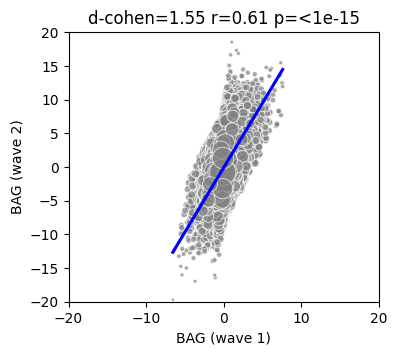

In [5]:
plt.figure(figsize=(4,3.5))
df = BAGs_data_longitudinal.copy()

df['GAP_diff'] = df['GAP_corrected_w2'] - df['GAP_corrected_w1']
Q1 = df['GAP_diff'].quantile(0.25)
Q3 = df['GAP_diff'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

from scipy import stats

df['z_score'] = stats.zscore(df['GAP_diff'])

outliers = df[(df['GAP_diff'] < lower_bound) | (df['GAP_diff'] > upper_bound)]
outliers2 = df[(df['z_score'] > 3) | (df['z_score'] < -3)]


df = df[(df['GAP_diff'] >= lower_bound) & (df['GAP_diff'] <= upper_bound)]
df.reset_index(inplace = True, drop = True)

df['GAP_corrected_w1'] = df['GAP_corrected_w1']/df['delta_time']

display(df.shape)

coords = np.vstack([df['GAP_corrected_w1'], df['GAP_corrected_w2']]).T
nbrs = NearestNeighbors(n_neighbors=500).fit(coords)  
distances, _ = nbrs.kneighbors(coords)
density = 1 / (np.mean(distances, axis=1) + 1e-10) 


point_sizes = 500 * (density / density.max())

sns.scatterplot(x='GAP_corrected_w1', y='GAP_corrected_w2', data=df, s=point_sizes, alpha=0.7, color='gray')

slope, intercept, r_value, p_value, std_err = stats.linregress(df['GAP_corrected_w1'], df['GAP_corrected_w2'])


confidence_interval = 2.58 * std_err 
slope_ci_lower = slope - confidence_interval
slope_ci_upper = slope + confidence_interval

sns.regplot(x='GAP_corrected_w1', y='GAP_corrected_w2', data=df, 
                scatter=False,  
                line_kws={'label': f'(Slope={slope:.2f} [{slope_ci_lower:.2f}, {slope_ci_upper:.2f}], r={r_value:.2f}, p={p_value:.3f})'}, 
                color='blue', ci=99)

y = df['GAP_corrected_w2']
X = sm.add_constant(df['GAP_corrected_w1'])


r_value = np.abs(r_value)
d_cohen = (2 * r_value) / np.sqrt(1 - r_value**2)


if(p_value<1e-15):
    p_value = '<1e-15'
plt.title(f'd-cohen={d_cohen:.2f} r={r_value:.2f} p={p_value}')
    


plt.xlim([-20, 20])
plt.ylim([-20, 20])
#plt.legend();

plt.xlabel('BAG (wave 1)')
plt.ylabel('BAG (wave 2)')


## BAGs versus healthy with moderation

(20597, 10)

Text(0, 0.5, 'Cognition (wave 2)')

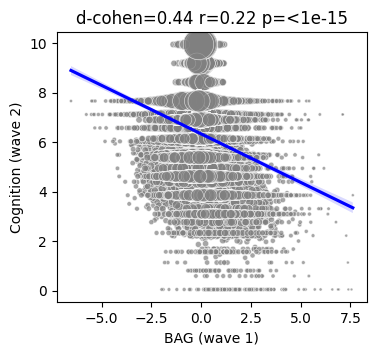

In [6]:
plt.figure(figsize=(4,3.5))
df = BAGs_data_longitudinal.copy()


df['GAP_diff'] = df['GAP_corrected_w2'] - df['GAP_corrected_w1']
Q1 = df['GAP_diff'].quantile(0.25)
Q3 = df['GAP_diff'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

from scipy import stats

df['z_score'] = stats.zscore(df['GAP_diff'])

outliers = df[(df['GAP_diff'] < lower_bound) | (df['GAP_diff'] > upper_bound)]
outliers2 = df[(df['z_score'] > 3) | (df['z_score'] < -3)]


df = df[(df['GAP_diff'] >= lower_bound) & (df['GAP_diff'] <= upper_bound)]
df.reset_index(inplace = True, drop = True)

display(df.shape)

df['GAP_corrected_w1'] = df['GAP_corrected_w1']/df['delta_time']


coords = np.vstack([df['GAP_corrected_w1'], df['Cognition_w2']]).T
nbrs = NearestNeighbors(n_neighbors=500).fit(coords) 
distances, _ = nbrs.kneighbors(coords)
density = 1 / (np.mean(distances, axis=1) + 1e-10) 


point_sizes = 500 * (density / density.max())

sns.scatterplot(x='GAP_corrected_w1', y='Cognition_w2', data=df, s=point_sizes, alpha=0.7, color='gray')

slope, intercept, r_value, p_value, std_err = stats.linregress(df['GAP_corrected_w1'], df['Cognition_w2'])


confidence_interval = 2.58 * std_err 
slope_ci_lower = slope - confidence_interval
slope_ci_upper = slope + confidence_interval

sns.regplot(x='GAP_corrected_w1', y='Cognition_w2', data=df, 
                scatter=False,  
                line_kws={'label': f'(Slope={slope:.2f} [{slope_ci_lower:.2f}, {slope_ci_upper:.2f}], r={r_value:.2f}, p={p_value:.3f})'}, 
                color='blue', ci=99)



y = df['Cognition_w2']
X = sm.add_constant(df['GAP_corrected_w1'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)


slope, intercept, r_value, p_value, std_err = stats.linregress(X_train['GAP_corrected_w1'], y_train)

r_value = np.abs(r_value)
d_cohen = (2 * r_value) / np.sqrt(1 - r_value**2)


if(p_value<1e-15):
    p_value = '<1e-15'
plt.title(f'd-cohen={d_cohen:.2f} r={r_value:.2f} p={p_value}')
    

plt.xlabel('BAG (wave 1)')
plt.ylabel('Cognition (wave 2)')


(20597, 10)

Text(0, 0.5, 'Funtional ability (wave 2)')

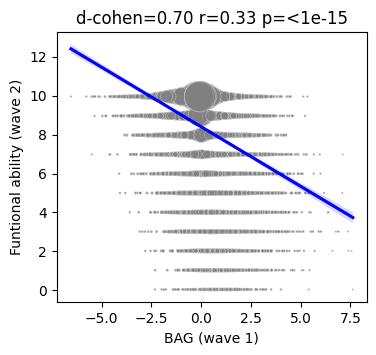

In [7]:
plt.figure(figsize=(4,3.5))
df = BAGs_data_longitudinal.copy()


df['GAP_diff'] = df['GAP_corrected_w2'] - df['GAP_corrected_w1']
Q1 = df['GAP_diff'].quantile(0.25)
Q3 = df['GAP_diff'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

from scipy import stats

df['z_score'] = stats.zscore(df['GAP_diff'])

outliers = df[(df['GAP_diff'] < lower_bound) | (df['GAP_diff'] > upper_bound)]
outliers2 = df[(df['z_score'] > 3) | (df['z_score'] < -3)]


df = df[(df['GAP_diff'] >= lower_bound) & (df['GAP_diff'] <= upper_bound)]
df.reset_index(inplace = True, drop = True)

display(df.shape)

df['GAP_corrected_w1'] = df['GAP_corrected_w1']/df['delta_time']

coords = np.vstack([df['GAP_corrected_w1'], df['Barthel_w2']]).T
nbrs = NearestNeighbors(n_neighbors=500).fit(coords) 
distances, _ = nbrs.kneighbors(coords)
density = 1 / (np.mean(distances, axis=1) + 1e-10) 


point_sizes = 500 * (density / density.max())

sns.scatterplot(x='GAP_corrected_w1', y='Barthel_w2', data=df, s=point_sizes, alpha=0.7, color='gray')

slope, intercept, r_value, p_value, std_err = stats.linregress(df['GAP_corrected_w1'], df['Barthel_w2'])

confidence_interval = 2.58 * std_err 
slope_ci_lower = slope - confidence_interval
slope_ci_upper = slope + confidence_interval

sns.regplot(x='GAP_corrected_w1', y='Barthel_w2', data=df, 
                scatter=False,  
                line_kws={'label': f'(Slope={slope:.2f} [{slope_ci_lower:.2f}, {slope_ci_upper:.2f}], r={r_value:.2f}, p={p_value:.3f})'}, 
                color='blue', ci=99)


y = df['Barthel_w2']
X = sm.add_constant(df['GAP_corrected_w1'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

slope, intercept, r_value, p_value, std_err = stats.linregress(X_train['GAP_corrected_w1'], y_train)

r_value = np.abs(r_value)
d_cohen = (2 * r_value) / np.sqrt(1 - r_value**2)

if(p_value<1e-15):
    p_value = '<1e-15'
plt.title( f'd-cohen={d_cohen:.2f} r={r_value:.2f} p={p_value}')
    

plt.xlabel('BAG (wave 1)')
plt.ylabel('Funtional ability (wave 2)')



(20597, 10)

Text(0, 0.5, 'Wellbeing (wave 2)')

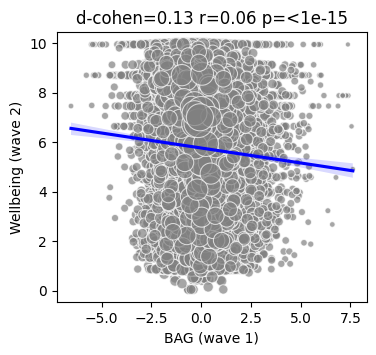

In [8]:
plt.figure(figsize=(4,3.5))
df = BAGs_data_longitudinal.copy()


df['GAP_diff'] = df['GAP_corrected_w2'] - df['GAP_corrected_w1']
Q1 = df['GAP_diff'].quantile(0.25)
Q3 = df['GAP_diff'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

from scipy import stats

df['z_score'] = stats.zscore(df['GAP_diff'])

outliers = df[(df['GAP_diff'] < lower_bound) | (df['GAP_diff'] > upper_bound)]
outliers2 = df[(df['z_score'] > 3) | (df['z_score'] < -3)]


df = df[(df['GAP_diff'] >= lower_bound) & (df['GAP_diff'] <= upper_bound)]
df.reset_index(inplace = True, drop = True)

display(df.shape)

df['GAP_corrected_w1'] = df['GAP_corrected_w1']/df['delta_time']

coords = np.vstack([df['GAP_corrected_w1'], df['Well_being_domain_w2']]).T
nbrs = NearestNeighbors(n_neighbors=500).fit(coords) 
distances, _ = nbrs.kneighbors(coords)
density = 1 / (np.mean(distances, axis=1) + 1e-10) 


point_sizes = 500 * (density / density.max())

sns.scatterplot(x='GAP_corrected_w1', y='Well_being_domain_w2', data=df, s=point_sizes, alpha=0.7, color='gray')

slope, intercept, r_value, p_value, std_err = stats.linregress(df['GAP_corrected_w1'], df['Well_being_domain_w2'])

confidence_interval = 2.58 * std_err 
slope_ci_lower = slope - confidence_interval
slope_ci_upper = slope + confidence_interval

sns.regplot(x='GAP_corrected_w1', y='Well_being_domain_w2', data=df, 
                scatter=False, 
                line_kws={'label': f'(Slope={slope:.2f} [{slope_ci_lower:.2f}, {slope_ci_upper:.2f}], r={r_value:.2f}, p={p_value:.3f})'}, 
                color='blue', ci=99)



y = df['Well_being_domain_w2']
X = sm.add_constant(df['GAP_corrected_w1'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2)


r_value = np.abs(r_value)
d_cohen = (2 * r_value) / np.sqrt(1 - r_value**2)

if(p_value<1e-15):
    p_value = '<1e-15'
plt.title( f'd-cohen={d_cohen:.2f} r={r_value:.2f} p={p_value}')
    

plt.xlabel('BAG (wave 1)')
plt.ylabel('Wellbeing (wave 2)')

